In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
from torchinfo import summary

- The first parameter is SEQ_LENGTH which the value is set to 200 (marked with #(1) in Codeblock 2 below). This is essentially done because we want the model to capture a sequence of exactly 200 tokens. If the sequence is longer, it will be truncated. Meanwhile, if it has fewer than 200 tokens, padding will be applied. 

- The subsequent parameters are VOCAB_SIZE_SRC (#(2)) and VOCAB_SIZE_DST (#(3)), in which the former denotes the number of unique tokens possible to appear in the original sequence, while the latter is the same thing but for the translated sequence. 

- The D_MODEL and NUM_HEADS parameters on the other hand, are something that you cannot choose arbitrarily, in a sense that D_MODEL (#(5)) needs to be divisible by NUM_HEADS (#(6)). The D_MODEL itself corresponds to the model dimension, which is actually also equivalent to the embedding dimension.

- This notion implies that every single token is going to be represented as a vector of size 512. Meanwhile, NUM_HEADS=8 means that there will be 8 heads inside a Multihead Attention layer. 

- Later on, the 512 features of each token will be spread evenly into these 8 attention heads, so every single head will be responsible for handling 64 features (HEAD_DIM) as marked at line #(7)

- The HIDDEN_DIM parameter, which the value is set to 2048 (#(8)), denotes the number of neurons in the hidden layer inside the Feed Forward blocks. Next, if you go back to Figure 1, you will notice that there is a symbol N× next to the Encoder and the Decoder which essentially means that we can stack them N times. In this case, we set it to 6 as marked at line #(9)

-  Lastly, we can also control the rate of the dropout layers through the DROP_PROB parameter (#(10)).


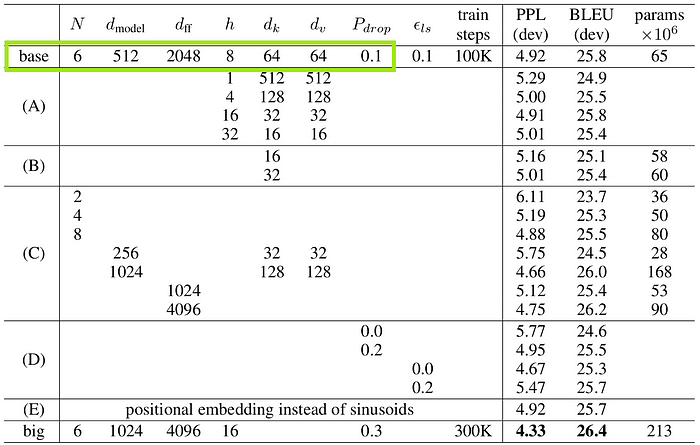

In [3]:
# Codeblock 2
SEQ_LENGTH     = 200    #(1)
VOCAB_SIZE_SRC = 100    #(2)
VOCAB_SIZE_DST = 120    #(3)

BATCH_SIZE = 1     #(4)
D_MODEL    = 512   #(5)
NUM_HEADS  = 8     #(6)
HEAD_DIM   = D_MODEL//NUM_HEADS    # 512 // 8 = 64    #(7)
HIDDEN_DIM = 2048  #(8)
N          = 6     #(9)
DROP_PROB  = 0.1   #(10)

In [4]:
class InputEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE_SRC,embedding_dim=D_MODEL)

    
    def forward(self,x):
        print(f"original\t:{x.shape}")
        x= self.embedding(x)
        print(f"After Embidding\t:{x.shape}")
        return x
    

In [5]:
class OutputEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE_DST,embedding_dim=D_MODEL)

    def forward(self,x):
        print(f"original\t:{x.shape}")
        x= self.embedding(x)
        print(f"After Embidding\t:{x.shape}")
        return x


- The InputEmbedding() and OutputEmbedding() classes above appear to be identical. However, if you take a closer look at the nn.Embedding() layer from the two classes (at the line marked with #(1) and #(3)), you will see that in InputEmbedding() I set the num_embeddings parameter to VOCAB_SIZE_SRC (100), while in OutputEmbedding() we set it to VOCAB_SIZE_DST (120). This approach allows us to handle two languages that have different vocabulary sizes, where in this case we assume that the source language and the destination language have the number of unique tokens of 100 and 120, respectively.

- Next, the forward() method of the two classes is completely the same, in which it works by accepting a sequence of tokens and return the result produced by the self.embedding() layer (#(2) and #(4)). Here I also print out the dimension of the tensor before and after processing so you can better understand how the tensors are actually processed.


In [6]:
# Testing Code for checking input and output embedding is working as expected

input_embedding = InputEmbedding()
x_src = torch.randint(0,VOCAB_SIZE_SRC,(BATCH_SIZE,SEQ_LENGTH))
x_src = input_embedding(x_src)

original	:torch.Size([1, 200])
After Embidding	:torch.Size([1, 200, 512])


In [7]:
output_embedding = OutputEmbedding()

x_dst = torch.randint(0, VOCAB_SIZE_DST, (BATCH_SIZE, SEQ_LENGTH))
x_dst = output_embedding(x_dst)

original	:torch.Size([1, 200])
After Embidding	:torch.Size([1, 200, 512])


In [8]:
class PositionalEncoding(nn.Module):

    def forward(self):
        pos = torch.arange(SEQ_LENGTH).reshape(SEQ_LENGTH, 1)  #(1)
        print(f"pos\t\t: {pos.shape}")
        
        i = torch.arange(0, D_MODEL, 2)  #(2)
        denominator = torch.pow(10000, i/D_MODEL)  #(3)
        print(f"denominator\t: {denominator.shape}")
        
        even_pos_embed = torch.sin(pos/denominator)  #(4)
        odd_pos_embed  = torch.cos(pos/denominator)  #(5)
        print(f"even_pos_embed\t: {even_pos_embed.shape}")
        
        stacked = torch.stack([even_pos_embed, odd_pos_embed], dim=2)  #(6)
        print(f"stacked\t\t: {stacked.shape}")

        pos_embed = torch.flatten(stacked, start_dim=1, end_dim=2)  #(7)
        print(f"pos_embed\t: {pos_embed.shape}")
        
        return pos_embed

In [9]:
# Codeblock 7
positional_encoding = PositionalEncoding()

positional_embedding = positional_encoding()
# Codeblock 7 output
pos            : torch.Size([200, 1])
denominator    : torch.Size([256])
even_pos_embed : torch.Size([200, 256])    #(1)
odd_pos_embed  : torch.Size([200, 256])    #(2)
stacked        : torch.Size([200, 256, 2])
pos_embed      : torch.Size([200, 512])    #(3)

pos		: torch.Size([200, 1])
denominator	: torch.Size([256])
even_pos_embed	: torch.Size([200, 256])
stacked		: torch.Size([200, 256, 2])
pos_embed	: torch.Size([200, 512])


In [10]:
 # Codeblock 8
class Attention(nn.Module):
 
    def create_mask(self):  #(1)
        mask = torch.tril(torch.ones((SEQ_LENGTH, SEQ_LENGTH)))  #(2)
        mask[mask == 0] = -float('inf')
        mask[mask == 1] = 0
        return mask.clone().detach()

    def forward(self, q, k, v, look_ahead_mask=False):  #(3)
        print(f"q\t\t\t: {q.shape}")
        print(f"k\t\t\t: {k.shape}")
        print(f"v\t\t\t: {v.shape}")
        
        multiplied = torch.matmul(q, k.transpose(-1,-2))  #(4)
        print(f"multiplied\t\t: {multiplied.shape}")
        
        scaled = multiplied / torch.sqrt(torch.tensor(HEAD_DIM))  #(5)
        print(f"scaled\t\t\t: {scaled.shape}")
        
        if look_ahead_mask == True:  #(6)
            mask = self.create_mask()
            print(f"mask\t\t\t: {mask.shape}")
            scaled += mask  #(7)
            
        attn_output_weights = torch.softmax(scaled, dim=-1)  #(8)
        print(f"attn_output_weights\t: {attn_output_weights.shape}")
        
        attn_output = torch.matmul(attn_output_weights, v)  #(9)
        print(f"attn_output\t\t: {attn_output.shape}")
        
        return attn_output, attn_output_weights  #(10)

In [11]:
# Codeblock 9
attention = Attention()

q = torch.randn(BATCH_SIZE, SEQ_LENGTH, HEAD_DIM)
k = torch.randn(BATCH_SIZE, SEQ_LENGTH, HEAD_DIM)
v = torch.randn(BATCH_SIZE, SEQ_LENGTH, HEAD_DIM)

attn_output, attn_output_weights = attention(q, k, v, look_ahead_mask=True)
# Codeblock 9 output
q                    : torch.Size([1, 200, 64])
k                    : torch.Size([1, 200, 64])
v                    : torch.Size([1, 200, 64])
multiplied           : torch.Size([1, 200, 200])  #(1)
scaled               : torch.Size([1, 200, 200])
mask                 : torch.Size([200, 200])
attn_output_weights  : torch.Size([1, 200, 200])
attn_output          : torch.Size([1, 200, 64])   #(2)

q			: torch.Size([1, 200, 64])
k			: torch.Size([1, 200, 64])
v			: torch.Size([1, 200, 64])
multiplied		: torch.Size([1, 200, 200])
scaled			: torch.Size([1, 200, 200])
mask			: torch.Size([200, 200])
attn_output_weights	: torch.Size([1, 200, 200])
attn_output		: torch.Size([1, 200, 64])


In [15]:
# Codeblock 10
class SelfAttention(nn.Module):

    def __init__(self, look_ahead_mask=False):  #(1)
        super().__init__()
        self.look_ahead_mask = look_ahead_mask

        self.qkv_linear = nn.Linear(D_MODEL, 3*D_MODEL)  #(2)
        self.attention = Attention()  #(3)
        self.linear = nn.Linear(D_MODEL, D_MODEL)  #(4)

    # Codeblock 11
    def forward(self, x):
        print(f"original\t\t: {x.shape}")
        
        x = self.qkv_linear(x)  #(1)
        print(f"after qkv_linear\t: {x.shape}")
        
        x = x.reshape(BATCH_SIZE, SEQ_LENGTH, NUM_HEADS, 3*HEAD_DIM)  #(2)
        print(f"after reshape\t\t: {x.shape}")
        
        x = x.permute(0, 2, 1, 3)  #(3)
        print(f"after permute\t\t: {x.shape}")
        
        q, k, v = x.chunk(3, dim=-1)  #(4)
        print(f"q\t\t\t: {q.shape}")
        print(f"k\t\t\t: {k.shape}")
        print(f"v\t\t\t: {v.shape}")
        
        attn_output, attn_output_weights = self.attention(q, k, v, 
                                                          look_ahead_mask=self.look_ahead_mask) #(5)
        print(f"attn_output\t\t: {attn_output.shape}")
        print(f"attn_output_weights\t: {attn_output_weights.shape}")
        
        x = attn_output.permute(0, 2, 1, 3)  #(6)
        print(f"after permute\t\t: {x.shape}")
        
        x = x.reshape(BATCH_SIZE, SEQ_LENGTH, NUM_HEADS*HEAD_DIM)  #(7)
        print(f"after reshape\t\t: {x.shape}")
        
        x = self.linear(x)  #(8)
        print(f"after linear\t\t: {x.shape}")
        
        return x

In [17]:
# Codeblock 12
self_attention = SelfAttention()

x = torch.randn(BATCH_SIZE, SEQ_LENGTH, D_MODEL)
x = self_attention(x)

original		: torch.Size([1, 200, 512])
after qkv_linear	: torch.Size([1, 200, 1536])
after reshape		: torch.Size([1, 200, 8, 192])
after permute		: torch.Size([1, 8, 200, 192])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
multiplied		: torch.Size([1, 8, 200, 200])
scaled			: torch.Size([1, 8, 200, 200])
attn_output_weights	: torch.Size([1, 8, 200, 200])
attn_output		: torch.Size([1, 8, 200, 64])
attn_output		: torch.Size([1, 8, 200, 64])
attn_output_weights	: torch.Size([1, 8, 200, 200])
after permute		: torch.Size([1, 200, 8, 64])
after reshape		: torch.Size([1, 200, 512])
after linear		: torch.Size([1, 200, 512])


In [18]:
# Codeblock 13
class CrossAttention(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.kv_linear = nn.Linear(D_MODEL, 2*D_MODEL)  #(1)
        self.q_linear = nn.Linear(D_MODEL, D_MODEL)  #(2)
        self.attention = Attention()
        self.linear = nn.Linear(D_MODEL, D_MODEL)  #(3)
    
# Codeblock 14
    def forward(self, x_enc, x_dec):  #(1)
        print(f"x_enc original\t\t: {x_enc.shape}")
        print(f"x_dec original\t\t: {x_dec.shape}")
        
        x_enc = self.kv_linear(x_enc)  #(2)
        print(f"\nafter kv_linear\t\t: {x_enc.shape}")
        
        x_enc = x_enc.reshape(BATCH_SIZE, SEQ_LENGTH, NUM_HEADS, 2*HEAD_DIM)  #(3)
        print(f"after reshape\t\t: {x_enc.shape}")
        
        x_enc = x_enc.permute(0, 2, 1, 3)  #(4)
        print(f"after permute\t\t: {x_enc.shape}")
        
        k, v = x_enc.chunk(2, dim=-1)  #(5)
        print(f"k\t\t\t: {k.shape}")
        print(f"v\t\t\t: {v.shape}")
        

        x_dec = self.q_linear(x_dec)  #(6)
        print(f"\nafter q_linear\t\t: {x_dec.shape}")
        
        x_dec = x_dec.reshape(BATCH_SIZE, SEQ_LENGTH, NUM_HEADS, HEAD_DIM)  #(7)
        print(f"after reshape\t\t: {x_dec.shape}")
        
        q = x_dec.permute(0, 2, 1, 3)  #(8)
        print(f"after permute (q)\t: {q.shape}")
        

        attn_output, attn_output_weights = self.attention(q, k, v) #(9)
        print(f"\nattn_output\t\t: {attn_output.shape}")
        print(f"attn_output_weights\t: {attn_output_weights.shape}")
        
        x = attn_output.permute(0, 2, 1, 3)
        print(f"after permute\t\t: {x.shape}")
        
        x = x.reshape(BATCH_SIZE, SEQ_LENGTH, NUM_HEADS*HEAD_DIM)
        print(f"after reshape\t\t: {x.shape}")
        
        x = self.linear(x)
        print(f"after linear\t\t: {x.shape}")
        
        return x

In [19]:
# Codeblock 15
cross_attention = CrossAttention()

x_enc = torch.randn(BATCH_SIZE, SEQ_LENGTH, D_MODEL)
x_dec = torch.randn(BATCH_SIZE, SEQ_LENGTH, D_MODEL)

x = cross_attention(x_enc, x_dec)

x_enc original		: torch.Size([1, 200, 512])
x_dec original		: torch.Size([1, 200, 512])

after kv_linear		: torch.Size([1, 200, 1024])
after reshape		: torch.Size([1, 200, 8, 128])
after permute		: torch.Size([1, 8, 200, 128])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])

after q_linear		: torch.Size([1, 200, 512])
after reshape		: torch.Size([1, 200, 8, 64])
after permute (q)	: torch.Size([1, 8, 200, 64])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
multiplied		: torch.Size([1, 8, 200, 200])
scaled			: torch.Size([1, 8, 200, 200])
attn_output_weights	: torch.Size([1, 8, 200, 200])
attn_output		: torch.Size([1, 8, 200, 64])

attn_output		: torch.Size([1, 8, 200, 64])
attn_output_weights	: torch.Size([1, 8, 200, 200])
after permute		: torch.Size([1, 200, 8, 64])
after reshape		: torch.Size([1, 200, 512])
after linear		: torch.Size([1, 200, 512])


In [20]:
# Codeblock 16
class FeedForward(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.linear_0 = nn.Linear(D_MODEL, HIDDEN_DIM)  #(1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROP_PROB)  #(2)
        self.linear_1 = nn.Linear(HIDDEN_DIM, D_MODEL)  #(3)
    
    def forward(self, x):
        print(f"original\t: {x.shape}")
        
        x = self.linear_0(x)
        print(f"after linear_0\t: {x.shape}")
        
        x = self.relu(x)
        print(f"after relu\t: {x.shape}")
        
        x = self.dropout(x)
        print(f"after dropout\t: {x.shape}")
        
        x = self.linear_1(x)
        print(f"after linear_1\t: {x.shape}")
        
        return x

In [21]:
feed_forward = FeedForward()

x = torch.randn(BATCH_SIZE, SEQ_LENGTH, D_MODEL)
x = feed_forward(x)

original	: torch.Size([1, 200, 512])
after linear_0	: torch.Size([1, 200, 2048])
after relu	: torch.Size([1, 200, 2048])
after dropout	: torch.Size([1, 200, 2048])
after linear_1	: torch.Size([1, 200, 512])


In [22]:
# Codeblock 18
class LayerNorm(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps  #(1)
        self.gamma = nn.Parameter(torch.ones(D_MODEL), requires_grad=True)  #(2)
        self.beta = nn.Parameter(torch.zeros(D_MODEL), requires_grad=True)  #(3)
    
    def forward(self, x):  #(4)
        print(f"original\t: {x.shape}")
        
        mean = x.mean(dim=[-1], keepdim=True)  #(5)
        print(f"mean\t\t: {mean.shape}")
        
        var = ((x - mean) ** 2).mean(dim=[-1], keepdim=True)  #(6)
        print(f"var\t\t: {var.shape}")
        
        stddev = (var + self.eps).sqrt()  #(7)
        print(f"stddev\t\t: {stddev.shape}")
        
        x = (x - mean) / stddev  #(8)
        print(f"normalized\t: {x.shape}")
        
        x = (self.gamma * x) + self.beta  #(9)
        print(f"after scaling and shifting\t: {x.shape}")
        
        return x

In [23]:
layer_norm = LayerNorm()

x = torch.randn(BATCH_SIZE, SEQ_LENGTH, D_MODEL)
x = layer_norm(x)

original	: torch.Size([1, 200, 512])
mean		: torch.Size([1, 200, 1])
var		: torch.Size([1, 200, 1])
stddev		: torch.Size([1, 200, 1])
normalized	: torch.Size([1, 200, 512])
after scaling and shifting	: torch.Size([1, 200, 512])


In [24]:
# Codeblock 20
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.self_attention = SelfAttention(look_ahead_mask=False)  #(1)
        self.dropout_0 = nn.Dropout(DROP_PROB)  #(2)
        self.layer_norm_0 = LayerNorm()         #(3)
        self.feed_forward = FeedForward()
        self.dropout_1 = nn.Dropout(DROP_PROB)  #(4)
        self.layer_norm_1 = LayerNorm()         #(5)

    def forward(self, x):
        residual = x
        print(f"original & residual\t: {x.shape}")
        
        x = self.self_attention(x)  #(6)
        print(f"after self attention\t: {x.shape}")
        
        x = self.dropout_0(x)  #(7)
        print(f"after dropout\t\t: {x.shape}")
        
        x = self.layer_norm_0(x + residual)  #(8)
        print(f"after layer norm\t: {x.shape}")
        

        residual = x
        print(f"\nx & residual\t\t: {x.shape}")
        
        x = self.feed_forward(x)  #(9)
        print(f"after feed forward\t: {x.shape}")
        
        x = self.dropout_1(x)
        print(f"after dropout\t\t: {x.shape}")
        
        x = self.layer_norm_1(x + residual)
        print(f"after layer norm\t: {x.shape}")
        
        return x

In [25]:
encoder = Encoder()

x = torch.randn(BATCH_SIZE, SEQ_LENGTH, D_MODEL)
x = encoder(x)

original & residual	: torch.Size([1, 200, 512])
original		: torch.Size([1, 200, 512])
after qkv_linear	: torch.Size([1, 200, 1536])
after reshape		: torch.Size([1, 200, 8, 192])
after permute		: torch.Size([1, 8, 200, 192])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
multiplied		: torch.Size([1, 8, 200, 200])
scaled			: torch.Size([1, 8, 200, 200])
attn_output_weights	: torch.Size([1, 8, 200, 200])
attn_output		: torch.Size([1, 8, 200, 64])
attn_output		: torch.Size([1, 8, 200, 64])
attn_output_weights	: torch.Size([1, 8, 200, 200])
after permute		: torch.Size([1, 200, 8, 64])
after reshape		: torch.Size([1, 200, 512])
after linear		: torch.Size([1, 200, 512])
after self attention	: torch.Size([1, 200, 512])
after dropout		: torch.Size([1, 200, 512])
original	: torch.Size([1, 200, 512])
mean		: torch.Size([1, 200, 1])
var		: tor

In [26]:
# Codeblock 22
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.self_attention = SelfAttention(look_ahead_mask=True)  #(1)
        self.dropout_0 = nn.Dropout(DROP_PROB)  #(2)
        self.layer_norm_0 = LayerNorm()
        
        self.cross_attention = CrossAttention()  #(3)
        self.dropout_1 = nn.Dropout(DROP_PROB)  #(4)
        self.layer_norm_1 = LayerNorm()
        
        self.feed_forward = FeedForward()
        self.dropout_2 = nn.Dropout(DROP_PROB)  #(5)
        self.layer_norm_2 = LayerNorm()
    
    def forward(self, x_enc, x_dec):  #(6)
        residual = x_dec
        print(f"x_dec & residual\t: {x_dec.shape}")
        
        x_dec = self.self_attention(x_dec)  #(7)
        print(f"after self attention\t: {x_dec.shape}")
        
        x_dec = self.dropout_0(x_dec)
        print(f"after dropout\t\t: {x_dec.shape}")
        
        x_dec = self.layer_norm_0(x_dec + residual)  #(8)
        print(f"after layer norm\t: {x_dec.shape}")
        
        residual = x_dec
        print(f"\nx_dec & residual\t: {x_dec.shape}")
        
        x_dec = self.cross_attention(x_enc, x_dec)  #(9)
        print(f"after cross attention\t: {x_dec.shape}")
        
        x_dec = self.dropout_1(x_dec)
        print(f"after dropout\t\t: {x_dec.shape}")
        
        x_dec = self.layer_norm_1(x_dec + residual)
        print(f"after layer norm\t: {x_dec.shape}")
        
        residual = x_dec
        print(f"\nx_dec & residual\t: {x_dec.shape}")
        
        x_dec = self.feed_forward(x_dec)  #(10)
        print(f"after feed forward\t: {x_dec.shape}")
        
        x_dec = self.dropout_2(x_dec)
        print(f"after dropout\t\t: {x_dec.shape}")
        
        x_dec = self.layer_norm_2(x_dec + residual)
        print(f"after layer norm\t: {x_dec.shape}")
        
        return x_dec

In [27]:
decoder = Decoder()

x_enc = torch.randn(BATCH_SIZE, SEQ_LENGTH, D_MODEL)
x_dec = torch.randn(BATCH_SIZE, SEQ_LENGTH, D_MODEL)

x = decoder(x_enc, x_dec)

x_dec & residual	: torch.Size([1, 200, 512])
original		: torch.Size([1, 200, 512])
after qkv_linear	: torch.Size([1, 200, 1536])
after reshape		: torch.Size([1, 200, 8, 192])
after permute		: torch.Size([1, 8, 200, 192])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
multiplied		: torch.Size([1, 8, 200, 200])
scaled			: torch.Size([1, 8, 200, 200])
mask			: torch.Size([200, 200])
attn_output_weights	: torch.Size([1, 8, 200, 200])
attn_output		: torch.Size([1, 8, 200, 64])
attn_output		: torch.Size([1, 8, 200, 64])
attn_output_weights	: torch.Size([1, 8, 200, 200])
after permute		: torch.Size([1, 200, 8, 64])
after reshape		: torch.Size([1, 200, 512])
after linear		: torch.Size([1, 200, 512])
after self attention	: torch.Size([1, 200, 512])
after dropout		: torch.Size([1, 200, 512])
original	: torch.Size([1, 200, 512])
mean		: torch

In [29]:
# Codeblock 24
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_embedding = InputEmbedding()  #(1)
        self.output_embedding = OutputEmbedding()  #(2)

        self.positional_encoding = PositionalEncoding()  #(3)

        self.encoders = nn.ModuleList([Encoder() for _ in range(N)])  #(4)
        self.decoders = nn.ModuleList([Decoder() for _ in range(N)])  #(5)

        self.linear = nn.Linear(D_MODEL, VOCAB_SIZE_DST)  #(6)
# Codeblock 25
    def forward(self, x_enc_raw, x_dec_raw):  #(1)
        print(f"x_enc_raw\t\t: {x_enc_raw.shape}")
        print(f"x_dec_raw\t\t: {x_dec_raw.shape}")
        
        # Encoder
        x_enc = self.input_embedding(x_enc_raw)  #(2)
        print(f"\nafter input embedding\t: {x_enc.shape}")
        
        x_enc = x_enc + self.positional_encoding()  #(3)
        print(f"after pos encoding\t: {x_enc.shape}")
        
        for i, encoder in enumerate(self.encoders):
            x_enc = encoder(x_enc)  #(4)
            print(f"after encoder #{i}\t: {x_enc.shape}")
            
        
        # Decoder
        x_dec = self.output_embedding(x_dec_raw)  #(5)
        print(f"\nafter output embedding\t: {x_dec.shape}")
        
        x_dec = x_dec + self.positional_encoding()  #(6)
        print(f"after pos encoding\t: {x_dec.shape}")
        
        for i, decoder in enumerate(self.decoders):
            x_dec = decoder(x_enc, x_dec)  #(7)
            print(f"after decoder #{i}\t: {x_dec.shape}")
            
        x = self.linear(x_dec)  #(8)
        print(f"\nafter linear\t\t: {x.shape}")
        
        return x

In [30]:
transformer = Transformer()

x_enc_raw = torch.randint(0, VOCAB_SIZE_SRC, (BATCH_SIZE, SEQ_LENGTH))
x_dec_raw = torch.randint(0, VOCAB_SIZE_DST, (BATCH_SIZE, SEQ_LENGTH))

In [31]:
y = transformer(x_enc_raw, x_dec_raw).shape


x_enc_raw		: torch.Size([1, 200])
x_dec_raw		: torch.Size([1, 200])
original	:torch.Size([1, 200])
After Embidding	:torch.Size([1, 200, 512])

after input embedding	: torch.Size([1, 200, 512])
pos		: torch.Size([200, 1])
denominator	: torch.Size([256])
even_pos_embed	: torch.Size([200, 256])
stacked		: torch.Size([200, 256, 2])
pos_embed	: torch.Size([200, 512])
after pos encoding	: torch.Size([1, 200, 512])
original & residual	: torch.Size([1, 200, 512])
original		: torch.Size([1, 200, 512])
after qkv_linear	: torch.Size([1, 200, 1536])
after reshape		: torch.Size([1, 200, 8, 192])
after permute		: torch.Size([1, 8, 200, 192])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
multiplied		: torch.Size([1, 8, 200, 200])
scaled			: torch.Size([1, 8, 200, 200])
attn_output_weights	: torch.Size([1, 8, 200, 200])
attn_output		: torch.Size(

In [32]:
transformer = Transformer()
summary(transformer, input_data=(x_enc_raw, x_dec_raw))

x_enc_raw		: torch.Size([1, 200])
x_dec_raw		: torch.Size([1, 200])
original	:torch.Size([1, 200])
After Embidding	:torch.Size([1, 200, 512])

after input embedding	: torch.Size([1, 200, 512])
pos		: torch.Size([200, 1])
denominator	: torch.Size([256])
even_pos_embed	: torch.Size([200, 256])
stacked		: torch.Size([200, 256, 2])
pos_embed	: torch.Size([200, 512])
after pos encoding	: torch.Size([1, 200, 512])
original & residual	: torch.Size([1, 200, 512])
original		: torch.Size([1, 200, 512])
after qkv_linear	: torch.Size([1, 200, 1536])
after reshape		: torch.Size([1, 200, 8, 192])
after permute		: torch.Size([1, 8, 200, 192])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
q			: torch.Size([1, 8, 200, 64])
k			: torch.Size([1, 8, 200, 64])
v			: torch.Size([1, 8, 200, 64])
multiplied		: torch.Size([1, 8, 200, 200])
scaled			: torch.Size([1, 8, 200, 200])
attn_output_weights	: torch.Size([1, 8, 200, 200])
attn_output		: torch.Size(

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [1, 200, 120]             --
├─InputEmbedding: 1-1                    [1, 200, 512]             --
│    └─Embedding: 2-1                    [1, 200, 512]             51,200
├─PositionalEncoding: 1-2                [200, 512]                --
├─ModuleList: 1-3                        --                        --
│    └─Encoder: 2-2                      [1, 200, 512]             --
│    │    └─SelfAttention: 3-1           [1, 200, 512]             1,050,624
│    │    └─Dropout: 3-2                 [1, 200, 512]             --
│    │    └─LayerNorm: 3-3               [1, 200, 512]             1,024
│    │    └─FeedForward: 3-4             [1, 200, 512]             2,099,712
│    │    └─Dropout: 3-5                 [1, 200, 512]             --
│    │    └─LayerNorm: 3-6               [1, 200, 512]             1,024
│    └─Encoder: 2-3                      [1, 200, 512]       